# Generalized AutoRegressive Conditional Heteroskedacity (GARCH) Models
* Created on: 06/02/2021
* Created by: Michael Monahan

## Import the required librarys

In [22]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import time
import datetime
import requests
from arch import arch_model

## Why are GARCH models necessary?
* it is a popular method to model volatility
* this module will be broken down into four parts:
    1. GARCH model fundamentals
    2. GARCH model configuration
    3. Model performance evaluation
    4. pratcial applications of GARCH models
    
## Basics of financial volatility
* a *statistical measure of the dispersion* of financial asset returns over time
* most commonly computed as the standard deviation ($\sigma$) or variance ($\sigma^2$) of price returns
* in general, the higher the volatility, the riskier a financial asset which necessitates a higher return

### How to compute volatility in three steps:
* Step 1. Calculate returns as a percentage change     
* Step 2. Calculate the sample mean return
* Step 3. Caluculate the sample standard deviation

### To compute volatility in Python
* use pandas `.pct_change()` method to calculate retruns as a percentage change
```python
return_data = price_data.pct_change()
```
* use pandas `.std()` method to calculate volatility as standard deviation of returns
```python
volatility = return_data.std()
```
### Volatility conversion
* convert daily return to monthly volatility (assuming 21 trading days in a month)
    \begin{equation}
    \sigma_{monthly} = \sqrt21 * \sigma_{d}
    \end{equation}
* similarly, daily return volatility can be converted to an annual basis
    \begin{equation}
    \sigma_{annual} = \sqrt252 * \sigma_{d}
    \end{equation}
* one of the challenges, and assumptions is volatility remains constant over time (homoskedastic)
* this is rarely observed in 'real-life' return data, and volatility exhibits heteroskedastic properties

### Detecting heteroskedasticity
* visualize the data over time via scatter plot


## Retrive the data needed for this module
### Import the stock data from Yahoo Finance
* The url to [Yahoo Finance](https://finance.yahoo.com) was modified to allow greater flexibility with date ranges and selected equities.

In [11]:
# Select the S&P500 data for one year
ticker = "^GSPC"
period1 = int(time.mktime(datetime.datetime(2011,6,1,23,59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2021,6,1,23,59).timetuple()))
interval = '1d' # 1d, 1m
url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'


### Parse the dates and set the date column as an index

In [12]:
sp_price = pd.read_csv(url, parse_dates=['Date'])
sp_price = sp_price.sort_values(by = 'Date')
sp_price.set_index('Date', inplace = True)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-06-02,1314.550049,1318.030029,1305.609985,1312.939941,1312.939941,3762170000
2011-06-03,1312.939941,1312.939941,1297.900024,1300.160034,1300.160034,3505030000
2011-06-06,1300.260010,1300.260010,1284.719971,1286.170044,1286.170044,3555980000
2011-06-07,1286.310059,1296.219971,1284.739990,1284.939941,1284.939941,3846250000
2011-06-08,1284.630005,1287.040039,1277.420044,1279.560059,1279.560059,3970810000


## Visualize the data (S&P 500 Adjusted Closing Price 2011-2021)

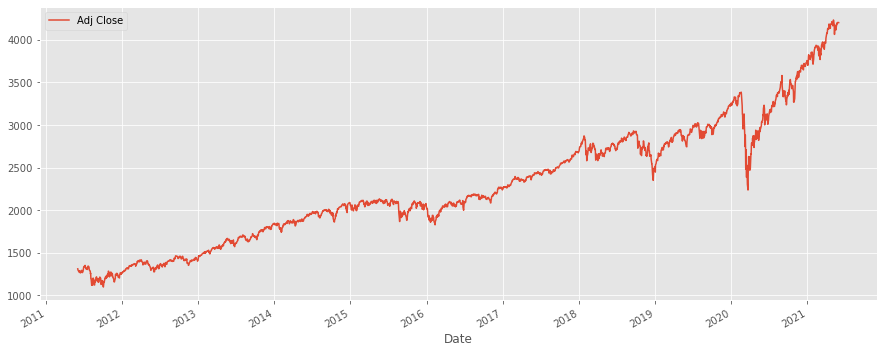

In [52]:
sp_price['Adj Close'].plot(figsize =(15,6))
plt.legend()
plt.show()

In [32]:
# Calculate daily returns as percentage price changes
sp_price['Return'] = 100 * (sp_price['Adj Close'].pct_change())

# View the data
print(sp_price.tail(10))

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-05-18  4165.939941  4169.149902  4125.990234  4127.830078  4127.830078   
2021-05-19  4098.450195  4116.930176  4061.409912  4115.680176  4115.680176   
2021-05-20  4121.970215  4172.799805  4121.970215  4159.120117  4159.120117   
2021-05-21  4168.609863  4188.720215  4151.720215  4155.859863  4155.859863   
2021-05-24  4170.160156  4209.520020  4170.160156  4197.049805  4197.049805   
2021-05-25  4205.939941  4213.419922  4182.520020  4188.129883  4188.129883   
2021-05-26  4191.589844  4202.609863  4184.109863  4195.990234  4195.990234   
2021-05-27  4201.939941  4213.379883  4197.779785  4200.879883  4200.879883   
2021-05-28  4210.770020  4218.359863  4203.569824  4204.109863  4204.109863   
2021-06-01  4216.520020  4234.120117  4197.589844  4202.040039  4202.040039   

                Volume    Return  
Date            

* Calculating the `.pct_change()` will generate NaN values which must be dropped before proceeding

In [33]:
sp_price['Return'].isnull().sum()

1

In [34]:
sp_price['Return'] = sp_price['Return'].dropna()

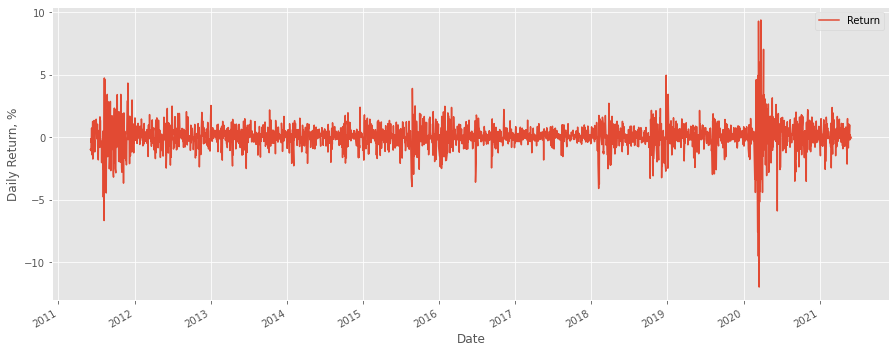

In [57]:
# plot the data
sp_price['Return'].plot(figsize=(15,6)).set_ylabel("Daily Return, %")
plt.legend()
plt.show()

In [61]:
# Calculate daily std of returns
std_daily = sp_price['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.2f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.2f}%'.format(std_annual))

Daily volatility:  1.10%
Monthly volatility:  5.06%
Annual volatility:  17.51%


## 1. GARCH model fundamentals
### First, some related statistical terms
* **White noise (z):** uncorrelated random variables with a zero mean and constant variance
* **Residual** = predicted value - observed value

### Model intuition
* it is autoregressive in that it predicts future behavior based on past behavior
* volatility is a weighted average of past information
* Intuitively, GARCH variance forecast can be interpreted as a weighted average of three different variance forecasts. 
    1. One is a constant variance that corresponds to the long run average. 
    2. The second is the new information that was not available when the previous forecast was made. 
    3. The third is the forecast that was made in the previous period. 
* The weights on these three forecasts determine how fast the variance changes with new information and how fast it reverts to its long run mean.

### Model constraints
* all parameters must be non-negative, i.e. the variance cannot be negative
    \begin{equation}
    \omega,\alpha,\beta >= 0
    \end{equation}
* model estimarions are 'mean-reverting' to the long-run variance
    \begin{equation}
    \alpha + \beta < 1
    \end{equation}
    long-run variance: 
    \begin{equation}
    \omega / (1 - \alpha - \beta)
    \end{equation}
* rules of thumb for model parameters
    1. the larger the $\alpha$ value, the bigger the immediate impact of the shock
    2. the larger the $\beta$ value, the longer the duration of the impact


## 2. GARCH model configuration
### GARCH Model workflow
* Three steps to develop the GARCH model
    1. Specify the model
    2. Fit the model
    3. Make a forecast
    
### Specify the model
* Model assumptions:
    1. Normal distribution of the residuals: `normal`,`t`,`skewt`
    2. Mean model: `constant`,`zero`,`AR`
    3. Volatility model: `GARCH`, `ARCH`,`EGARCH`


GARCH models enable one to specify the distribution assumptions of the standardized residuals. By default, a normal distribution is assumed, which has a symmetric, bell-shaped probability density curve. Other options include Student's t-distribution and skewed Student's t-distribution.

In [36]:
# Run the Shapiro-Wilk normality test
from scipy import stats
p_value = stats.shapiro(sp_price["Return"].dropna())[1]
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


In [79]:
# Build a basic GARCH model
gm_model = arch_model(sp_price['Return'].dropna(), p = 1, q = 1,
                     mean = 'constant', vol = 'GARCH', dist = 'normal')

### Fit the model
* display the model fit output after every *n* iterations
* fitted model parameters are determined by "maximum likelihood estimation"

In [80]:
gm_result = gm_model.fit(update_freq = 4, disp = 'off')
print(gm_result.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                            Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3008.89
Distribution:      Standardized Skew Student's t   AIC:                           6029.77
Method:                       Maximum Likelihood   BIC:                           6064.75
                                                   No. Observations:                 2515
Date:                           Wed, Jun 02 2021   Df Residuals:                     2514
Time:                                   16:43:57   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

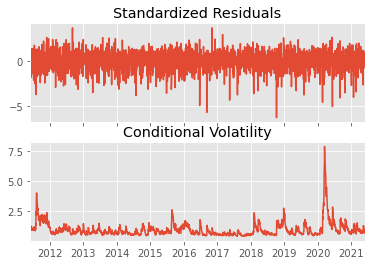

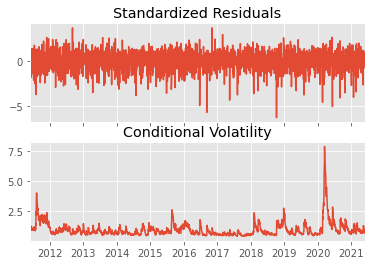

In [81]:
# Plot the fitted model results
gm_result.plot(figsize=(15,6))

## Make a forecast

In [74]:
## Make a 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-06-01  0.370847  0.394741  0.418365  0.441721  0.464813


C:\Users\Michael Monahan\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


## Distribution Assumptions
### Standardized residuals
* residual = predicted return - mean return
* standardized residual = residual / return volatility

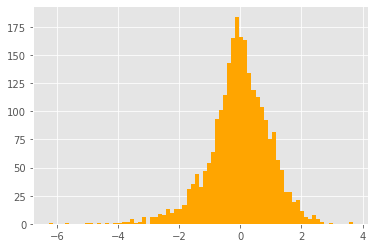

In [82]:

plt.hist(gm_std_resid, facecolor = 'orange', label = 'standardized residuals', bins = 75)
plt.show()

### Skewness of the residual distribution

In [83]:
# Import skew from scipy.stats
from scipy.stats import skew

# Calculate the third moment (skewness) of the returns distribution
gm_resid_skewness = skew(gm_std_resid)
print('The skewness of the residual distribution is: '+ str(gm_resid_skewness))

The skewness of the residual distribution is: -0.6810474400047537


### Kurtosis of the residual distribution

In [84]:
# Import kurtosis from scipy.stats
from scipy.stats import kurtosis

# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(gm_std_resid)
print('The excess kurtosis of the selected stock distribution is: '+ str(excess_kurtosis))

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis + 3
print('The fourth moment of the selected stock distribution is: ' + str(fourth_moment))

The excess kurtosis of the selected stock distribution is: 2.340683749284323
The fourth moment of the selected stock distribution is: 5.340683749284323


### Volatility models for asymmetric shocks
* GJR-GARCH was created to address the asymmetric shock to volatility
* to specify GJR-GARCH model add the paramter 'o = 1'
```python
arch_model(data, p  = 1, q = 1, o = 1, 
           mean = 'constant', vol = 'GARCH')
```
* EGARCH (Exponential GARCH) is another popular model to address asymmetric shocks
    * adds a conditional component to model asymmetric shock similar to GJR-GARCH model
    * No non-negative constraints on alpha or beta, so it tends to run faster
```python
arch_model(data, p  = 1, q = 1, o = 1, 
           mean = 'constant', vol = 'EGARCH')
```

In [ ]:
gjrgm_model = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, o = 1,
                     mean = 'constant', vol = 'GARCH', dist = 't')
gjrgm_model.summary()

In [ ]:
egm_model = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, o = 1,
                     mean = 'constant', vol = 'EGARCH', dist = 't')
egm_model.summary()

## GARCH rolling window forecast
### Rolling windows for out-of-sample forecasts: predicting the unknown
* **Rolling window forecast:** repeatedly perform model fitting and forecasting in time sequence
    * How to determine window size?
        * *Usually determined on a case-by-case basis*
        * Too wide window size: includes obsolete data that may lead to high bias
        * Too narrow window size: excludes relevant data that may lead to higher variance 
    * **The optimal window size: is a trade-off between model bias and variance**
        
* Implement an expanding window forecast
```python
for i in range (120):
    gm_result = basic_gm.fit(first_obs = start_loc,
                             last_obs = i + end_loc, disp = 'off')
    temp_result = gm_result.forecast(horizon = 1).variance
```
* Fixed rolling window forecast
```python 
for i in range(120):
    # Specify rolling window range for model fitting
    gm_result = basic_gm.fit(first_obs = i + start_loc,
                             last_obs = i + end_loc, disp = 'off')
    temp_result = gm_result.forecast(horizon = 1).variance
```

In [ ]:
# Print header of variance forecasts with expanding and fixed window
print(variance_expandwin.head())
print(variance_fixedwin.head())

# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)
# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue')
# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red')
plt.plot(bitcoin_data.Return['2019-4-1':'2019-9-15'], color = 'chocolate')
plt.show()

## Model parameter significance testing
* **Always select the parsimonious model**
* The significance level selected quantifies the probability of observing results purely by chance
    * 5% is a common threshold
* **p-value:** the odds the observed results could have happened by chance
    * the lower the p-value the less credibility the null hypothesis has
```python
# Print model fitting summary
print(gm_result.summary())
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})
# Print out parameter stats
print(para_summary)
```    
```python
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})
# Verify t-value by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']
# Print calculated t-statistic
print(calculated_t)
# Print parameter stats
print(para_summary)
```

### Validation of GARCH model assumptions
* One of the basic assumptions is the model caputures all of the information in the data and the only 'leftovers' are white noise processes. The following tests are conducted to ensure the residuals consist of white noise.
    1. ACF plots
    2. Ljung-Box test

* ACF plot in Python
```python
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, alpha = 0.05)
```
* Ljung-Box Test
    * tests whether any group of time series autocorrelations are different from zero
    

In [ ]:
# Run the Ljung-Box test to test for autocorrelation in the model residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
p_value = acorr_ljungbox(std_resid, lags = 10)[1]
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

### GARCH Model backtesting
* Backtesting is an approach to evaluate model forecasting capability
* allows comparisons between model predictions and actual historical data
* common measures of backtest performance include MAE and MSE
* to calculate MSE, MAE in Python:
```python
from sklearn.metrics import mean_absolute_error, mean_squared_error
```
```python
# Call function to calculate MAE
mae = mean_absolute_error(observation, forecast)
# Call function to calculate MSE
mse = mean_squared_error(observation, forecast)
```

In [ ]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse

# Backtest model with MAE, MSE
evaluate(actual_var, forecast_var)

## VaR in financial risk management
### Risk management mindset
* **Rule No. 1:** *Never lose money*
* **Rule No. 2:** *Never forget Rule No. 1*
* **VaR:** Value at Risk. A measure to quantify possible losses
    * Three requirements to determine VaR:
        1. portfoilo of assets
        2. time horizon
        3. probabilities
* VaR Example:
    * 1-day 5% VaR of 1 million USD = there is a 5% probability the portfolio will fall in value by 1M USD or more in 1 day

### Dynamic VaR with GARCH
* More realistic VaR estimation with GARCH
* VaR = *mean* + *(GARCH vol)* + *quantile*
```python
VaR = mean_forecast.values + np.sqrt(variance_forecast).values * quantile
```
#### Dynamic VaR calculation
* Step 1: Use GARCH model to make variance forecast
```python
# Specify and fit a GARCH model
egm = arch_model(egm_model = arch_model(sp_price['Return'].dropna(), p = 1, q = 1, o = 1,
                     mean = 'constant', vol = 'EGARCH', dist = 't')
gm_result = egm.fit()
# Make variance forecast
gm_forecast = gm_result.forecast(start = '2019-01-01')
```
* Step 2: Use GARCH model to obtain forward-looking mean and volatility
```python
mean_forecast = gm_forecast.mean['2019-01-01':]
variance_forecast = gm_forecast.variance['2019-01-01':]
```
* Step 3: Obtain the quantile according to a specified confidence level
1. Parametric VaR: determined by distribution
2. Emperical VaR: from historical data

* Parametric VaR: estimates quantiles based on GARCH assumeed distribution of standardized residuals
```python
# Assume a Student-t distribution
# ppf(): percent point function
q_parametric = egm.distribution.ppf(0.05, nu)
```
* Empirical VaR: estimates based on the observed distribution of GARCH standardized residuals
```python
q_empirical = std_resid.quantile(0.05)
```

In [ ]:
# Obtain the parametric quantile
q_parametric = egm.distribution.ppf(0.05, nu)
print('5% parametric quantile: ', q_parametric)
    
# Calculate the VaR
VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric
# Save VaR in a DataFrame
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = variance_forecast.index)

# Plot the VaR
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,sp_price.Return['2019-1-1':], color = 'orange', label = 'S&P Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()

# Obtain the empirical quantile
q_empirical = std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

# Calculate the VaR
VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
# Save VaR in a DataFrame
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = variance_forecast.index)

# Plot the VaRs
plt.plot(VaR_empirical, color = 'brown', label = '5% Empirical VaR')
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(variance_forecast.index,sp_price.Return['2019-1-1':], color = 'orange', label = 'S&P Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()

### Dynamic covariance in portfolio optimization
* **Covariance:** describes the relationship between movement of two variables
    * Positive covariance: variables move together in same direction
    * Negative covariance: variables move in opposite directions 
#### Calculate GARCH covariance in Python
* Step 1: Fit GARCH model and obtain volatility for each return series
```python
# gm_eur, gm_cad are fitted GARCH models
vol_eur = gm_eur.conditional_volatility
vol_cad = gm_cad.conditional_volatility
```
* Step 2: Compute standardized residuals from fitted GARCH models
* Step 3: Compute $\rho$ as simple correlation of standardized residuals
```python
corr = np.corrcoef(resid_eur, resid_cad)[0,1]
```
* Step 4: Compute GARCH covariance by multiplying the correlation and volatility
```python
covariance = corr * vol_eur * vol_cad
```

In [ ]:
# Define weights
Wa1 = 0.9
Wa2 = 1 - Wa1
Wb1 = 0.5
Wb2 = 1 - Wb1

# Calculate portfolio variance
portvar_a = Wa1**2 * variance_eur + Wa2**2 * variance_cad + 2*Wa1*Wa2 *covariance
portvar_b = Wb1**2 * variance_eur + Wb2**2 * variance_cad + 2*Wb1*Wb2*covariance

# Plot the data
plt.plot(portvar_a, color = 'green', label = 'Portfolio a')
plt.plot(portvar_b, color = 'deepskyblue', label = 'Portfolio b')
plt.legend(loc = 'upper right')
plt.show()